Возьму **очищенный** [датасет из второй ЛР](https://www.kaggle.com/datasets/padhmam/qs-world-university-rankings-2017-2022)

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

%matplotlib inline 
sns.set(style="ticks")

# Открою датасет
data = pd.read_csv('../lab-2/university-rankings-cleared.csv', sep=",")
# характеристики
print("размер:", data.shape)
print("\nколонки:\n", data.dtypes)
data.head()
data.describe()

размер: (2820, 12)

колонки:
 university                 object
year                        int64
score                     float64
country                    object
city                       object
region                     object
type                       object
research_output            object
student_faculty_ratio     float64
international_students      int64
size                       object
faculty_count               int64
dtype: object


,year,score,student_faculty_ratio,international_students,faculty_count
count,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000
mean,2019.640071,46.595532,10.652482,4483.347518,2561.719504
std,1.673794,18.813110,5.057507,4133.476621,1991.709499
min,2017.000000,23.500000,2.000000,5.000000,139.000000
25%,2018.000000,31.800000,7.000000,1747.000000,1218.000000
50%,2020.000000,40.600000,10.000000,3514.000000,2119.000000
75%,2021.000000,58.025000,13.000000,6062.000000,3354.000000
max,2022.000000,100.000000,44.000000,31049.000000,20311.000000


Разделю выборку. Целью исследования поставлю определение оценки университета, базируясь на качестве индивидуального отношения к студенту student_faculty_ratio (согласно авторам датасета, чем меньше число, тем обучение студента [более индивидуально](https://www.kaggle.com/code/padhmam?scriptVersionId=87338978&cellId=66])), числу иностранных студентов, кол-ва персонала, страны.

**score** =  F (**international_students**, **faculty_count**, **student_faculty_ratio**, **country**).

![](../lab-2/detaset_contents.png)

In [32]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

num_cols_list = []
cat_cols_list = []

for index, value in data.items():
  if (str(data[index].dtype) == "float64" or str(data[index].dtype) == "int64"):
    num_cols_list.append(index)
  elif str(data[index].dtype) == "object":
    cat_cols_list.append(index)

print(cat_cols_list)
print(num_cols_list)

['university', 'country', 'city', 'region', 'type', 'research_output', 'size']
['year', 'score', 'student_faculty_ratio', 'international_students', 'faculty_count']


Удалю данные, которые для исследования мне не нужны:

In [33]:
unused_cols = ['university', 'year', 'city', 'region', 'type', 'research_output', 'size']
data = data.drop(unused_cols, axis=1)


In [34]:
# сохраню возможность декодирования сюда
cat_names_decoding_map = dict()

counters_before_encoding = data['country'].unique().shape[0]

for cat in [cat for cat in cat_cols_list if cat not in unused_cols]:
  le = LabelEncoder()
  lables = le.fit_transform(data[cat])
  data[cat] = le.transform(data[cat])
  cat_names_decoding_map[cat] = {
    'encoder': le,
    'lables': lables,
  }

print(data.dtypes)
print(cat_names_decoding_map)
print(counters_before_encoding, '=', data['country'].unique().shape[0])

score                     float64
country                     int32
student_faculty_ratio     float64
international_students      int64
faculty_count               int64
dtype: object
{'country': {'encoder': LabelEncoder(), 'lables': array([60, 60, 60, ..., 50, 28,  7])}}
62 = 62


In [35]:
x_columns = [x for x in list(data.columns) if x != 'score']
print(x_columns)

['country', 'student_faculty_ratio', 'international_students', 'faculty_count']


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(data[x_columns], data['score'], test_size=0.2, random_state=1)
print('Размер тестовой выборки:', X_test.shape[0])
print('Размер тренировочной выборки:', X_train.shape[0])
print(X_train.head())
print()
print(Y_train.head())

Размер тестовой выборки: 564
Размер тренировочной выборки: 2256
      country  student_faculty_ratio  international_students  faculty_count
1216       60                    6.0                    1172           1733
2340       21                    7.0                    8311           2944
559        51                   15.0                    6979           3002
1223       60                   17.0                    1156           1700
2168       40                    7.0                     563           1608

1216    27.5
2340    86.3
559     52.9
1223    27.2
2168    30.5
Name: score, dtype: float64


In [39]:
def test_poly_model(x_array, y_array, degree=3):
  poly_model = LinearRegression(fit_intercept=False)
  # poly_model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
  #                     ('linear', LinearRegression(fit_intercept=False))])
  # poly_model.fit(x_array.reshape(-1, 1), y_array)
  poly_model.fit(x_array, y_array)
  # poly_y_pred = poly_model.predict(x_array.reshape(-1, 1))
  poly_y_pred = poly_model.predict(x_array)
  
  plt.plot(x_array, y_array, 'g.')
  plt.plot(x_array, poly_y_pred, 'ro')
  plt.show()
  
  # print('Степени полинома - {}'.format(poly_model.named_steps['linear'].coef_))

InvalidIndexError: (slice(None, None, None), None)

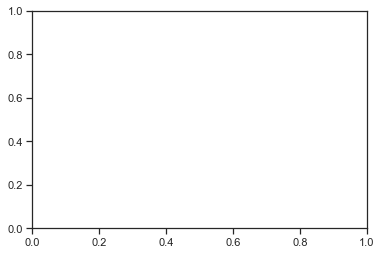

In [40]:
test_poly_model(X_train, Y_train)